# ПРЕДСКАЗАНИЯ РИСКОВ СЕРДЕЧНОГО ПРИСТУПА

## Описание проекта

Данные содержат следующие группы признаков:

1. Антропометрические параметры:

   * age - возраст
   * bmi - индекс массы тела
   * gender - пол
   * income - доход

2. Привычки:

   * smoking - курение (да\нет)
   * alcohol_consumption - употребление алкоголя (да\нет)
   * exercise_hours_per_week - часы тренировок за неделю
   * sedentary_hours_per_day - сидячие часы
   * physical_activity_days_per_week - дни с физической активностью за неделю
   * sleep_hours_per_day - часы сна в день
   * diet - тип диеты
   * stress_level - уровень стресса

3. Давление:

   * heart_rate - частота пульса
   * systolic_blood_pressure - систолическое давление (верхнее давление)
   * diastolic_blood_pressure - диастолическое давление (нижнее давление)

4. Наличие хронических заболеваний:

   * diabetes - диабет (есть\нет)
   * family_history - заболевания в семье (да\нет)
   * previous_heart_problems - предыдущие проблемы с сердцем (да\нет)
   * medication_use - прием лекарств (да\нет)
   * obesity - ожирение (да\нет)

5. Биохимия крови:

   * cholesterol - уровень холестирина
   * triglycerides - уровень триглециридов (жиров)
   * blood_sugar - сахар в крови
   * ck_mb - уровень креатинкиназы (фермента сердечной мышцы)
   * troponin - белок сердечной мышцы

6. Таргет:

   * heart_attack_risk_(binary) - риск сердечного приступа (есть\нет)

7. ID

## Загрузка данных

In [202]:
!pip install ipywidgets

In [203]:
#!pip install phik -q

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import catboost
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ( 
                            f1_score, roc_auc_score, 
                            accuracy_score, confusion_matrix, 
                            classification_report, 
                            ConfusionMatrixDisplay,
                            recall_score, precision_score,
                            roc_curve, auc
                            )

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer 

In [205]:
import shap
import phik

In [206]:
# устанавливаем настройки для отображения всех столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [207]:
# проверяем и загружаем данные
if os.path.exists('data/heart_train.csv'):
    train = pd.read_csv('data/heart_train.csv')
else:
    print('Файл heart_train.csv не найден')

if os.path.exists('data/heart_test.csv'):
    test = pd.read_csv('data/heart_test.csv')
else:
    print('Файл heart_test.csv не найден')

In [208]:
# функция для вывода датасетов
def check_df(df):
    display(df.shape)
    df.info()
    display(df.head(10))

In [209]:
check_df(train)

(8685, 28)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,1,1.0,0.0,7.0,0.558262,0.640836,0.110571,0.238961,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,2,0.0,1.0,9.0,0.827611,0.774609,0.073718,0.072727,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,2,0.0,1.0,7.0,0.225275,0.999364,0.001534,0.180519,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,0,1.0,1.0,3.0,0.828176,0.142208,0.093073,0.990909,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,1,0.0,0.0,7.0,0.692973,0.820952,0.145447,0.171429,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


In [210]:
check_df(test)

(966, 27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,2,0.0,1.0,8.0,0.044114,0.813517,0.723416,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,1,0.0,0.0,8.0,0.305998,0.562542,0.696128,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,1,1.0,0.0,1.0,0.377016,0.235091,0.484368,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,2,1.0,0.0,10.0,0.089371,0.486634,0.409407,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,2,1.0,1.0,8.0,0.524318,0.083936,0.657387,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519


**Вывод**: загрузили два датасета, train и test. По полученной первоначальной информации о них можно сделать следующие выводы:

1. train: 28 признаков, 8685 строк.
2. test: 27 признаков, 966 строк.

Во многих строках есть пропуски. Значения некоторых признаков (например, age) выглядят странно. Названия признаков нуждаются в привидении к единому стилю snake_case. Некоторые признаки (Diabetes, Family History, Smoking, Obesity и т.п.) нуждаются в смене типа данных, т.к. float занимает слишком много памяти.

Таргет - Heart Attack Risk (Binary). 

Нужно удалить в обоих датасетах признак Unnamed: 0, он дублирует нумерацию.

## Предобработка данных

In [211]:
# удалим ненужный столбец
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)

In [212]:
# функция для замены пробела и дефиса на нижнее подчеркивание
def names(columns):
    return [col.lower().replace(' ', '_').replace('-', '_') for col in columns]

In [213]:
# меняем названия
train.columns = names(train.columns)
test.columns = names(test.columns)

Удалили ненужный столбец и привели названия к виду snake_case. Теперь проверим наличие дубликатов и пропусков.

In [214]:
# функция для подсчета уникальных значенний и явных дубликатов
def check_duplicate(df, df_name):
    print(f'Таблица {df_name}')
    print(f'Дубликатов в таблице ', df.duplicated().sum())
    print(f'Уникальных значений в таблице', len(df) - df.duplicated().sum())

In [215]:
check_duplicate(train, 'train')

Таблица train
Дубликатов в таблице  0
Уникальных значений в таблице 8685


In [216]:
check_duplicate(test, 'test')

Таблица test
Дубликатов в таблице  0
Уникальных значений в таблице 966


Явных дубликатов в таблице нет. Проверим неявные в столбце gender.

In [217]:
print('train')
print('Столбец gender, число уникальных значений', train['gender'].nunique())
print(train['gender'].unique())
print('test')
print('Столбец gender, число уникальных значений', test['gender'].nunique())
print(test['gender'].unique())

train
Столбец gender, число уникальных значений 4
['Male' 'Female' '1.0' '0.0']
test
Столбец gender, число уникальных значений 4
['Male' 'Female' '1.0' '0.0']


In [218]:
display(train.query('(gender == "1.0") or (gender == "0.0")').head(10))
display(train.query('(gender == "1.0") or (gender == "0.0")').shape)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814,9528
90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209,9640
92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558,9515
185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163,9491
188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791,9448
204,0.674157,0.49978,0.065078,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.120553,0.002299,0.003010,1.0,0.167742,0.162791,9594
247,0.629213,0.49978,0.084326,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.150198,0.002933,0.133896,1.0,0.677419,0.720930,9570
392,0.370787,0.49978,0.067828,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.197628,0.119858,0.025439,1.0,0.258065,0.453488,9649
415,0.415730,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.140316,0.004435,0.001748,1.0,0.470968,0.593023,9625
416,0.404494,0.49978,0.102658,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.193676,0.009540,0.034275,1.0,0.387097,0.372093,9574


(243, 27)

In [219]:
display(train.query('diet == 3').head(10))
display(train.query('diet == 3').shape)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814,9528
90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209,9640
92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558,9515
185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163,9491
188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791,9448
204,0.674157,0.49978,0.065078,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.120553,0.002299,0.003010,1.0,0.167742,0.162791,9594
247,0.629213,0.49978,0.084326,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.150198,0.002933,0.133896,1.0,0.677419,0.720930,9570
392,0.370787,0.49978,0.067828,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.197628,0.119858,0.025439,1.0,0.258065,0.453488,9649
415,0.415730,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.140316,0.004435,0.001748,1.0,0.470968,0.593023,9625
416,0.404494,0.49978,0.102658,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.193676,0.009540,0.034275,1.0,0.387097,0.372093,9574


(243, 27)

Есть некоторая закономерность: в тех строках, где gender равен 1 или 0 (и непонятно, означает ли это male или female), пропущены значения во многих других признаках.

In [220]:
train.isna().sum()

age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk_(binary)           0
blood_sugar                          0
ck_mb                                0
troponin                             0
gender                               0
systolic_blood_pressure              0
diastolic_blood_pressure 

243 строки пропусков в train совпадают с 243-мя строками с неясными значениями gender и с 243-мя значениями diet = 3. Удалим их.

In [221]:
train = train[train['diet'] != 3]

Пропусков больше нет. Проверим в train уникальные значения бинарных признаков. Будем хранить бинарные признаки в int.

In [222]:
binary = ['diabetes', 'family_history',	'smoking', 'obesity', 'alcohol_consumption', 
          'previous_heart_problems', 'medication_use']

# функция выводит уникальные значения для бинарных признаков и преобразовывает в int
def process_binary_columns(df, binary_columns=binary):
    for col in binary_columns:
        df[col] = df[col].astype(int)
    
    print("\nБинарные признаки:")
    for col in binary_columns:
        print(f"{col}: {df[col].unique()} (тип: {df[col].dtype})")

In [223]:
process_binary_columns(train)


Бинарные признаки:
diabetes: [1 0] (тип: int64)
family_history: [1 0] (тип: int64)
smoking: [1 0] (тип: int64)
obesity: [1 0] (тип: int64)
alcohol_consumption: [1 0] (тип: int64)
previous_heart_problems: [1 0] (тип: int64)
medication_use: [0 1] (тип: int64)


In [224]:
# пусть 1 - мужчина, 0 - женщина
train['gender'] = train['gender'].map({'Male': 1, 'Female': 0})

Проверим тестовые данные.

In [225]:
display(test.query('(gender == "1.0") or (gender == "0.0")').head(10))
display(test.query('(gender == "1.0") or (gender == "0.0")').shape)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
27,0.370787,0.49978,0.034830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.181818,0.011843,0.000194,1.0,0.419355,0.441860,9613
37,0.573034,0.49978,0.043080,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.167984,0.011209,0.000971,1.0,0.722581,0.732558,9471
58,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.098814,0.036436,0.002233,1.0,0.387097,0.500000,9486
60,0.370787,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.199605,0.005970,0.006408,1.0,0.387097,0.220930,9391
61,0.483146,0.49978,0.028414,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.112648,0.013111,0.000680,1.0,0.419355,0.325581,9579
156,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.219368,1.000000,0.000583,1.0,0.335484,0.220930,9490
208,0.449438,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.264822,0.008906,0.002136,1.0,0.380645,0.186047,9617
235,0.325843,0.49978,0.029331,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.128458,0.002196,0.000583,0.0,0.387097,0.302326,9465
265,0.471910,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.083004,0.020218,0.000485,0.0,0.096774,0.441860,9562
339,0.348315,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.207510,0.006137,0.000388,0.0,0.174194,0.151163,9412


(31, 26)

In [226]:
test.isna().sum()

age                                 0
cholesterol                         0
heart_rate                          0
diabetes                           31
family_history                     31
smoking                            31
obesity                            31
alcohol_consumption                31
exercise_hours_per_week             0
diet                                0
previous_heart_problems            31
medication_use                     31
stress_level                       31
sedentary_hours_per_day             0
income                              0
bmi                                 0
triglycerides                       0
physical_activity_days_per_week    31
sleep_hours_per_day                 0
blood_sugar                         0
ck_mb                               0
troponin                            0
gender                              0
systolic_blood_pressure             0
diastolic_blood_pressure            0
id                                  0
dtype: int64

Удалим 31-у строку с пропусками. 

In [227]:
test = test[test['diet'] != 3]

In [228]:
process_binary_columns(test)


Бинарные признаки:
diabetes: [0 1] (тип: int64)
family_history: [1 0] (тип: int64)
smoking: [1 0] (тип: int64)
obesity: [1 0] (тип: int64)
alcohol_consumption: [1 0] (тип: int64)
previous_heart_problems: [0 1] (тип: int64)
medication_use: [0 1] (тип: int64)


In [229]:
test['gender'] = test['gender'].map({'Male': 1, 'Female': 0})

**Вывод:** на этапе предобработки данных было выполнено:

1. Удален столбец Unnamed: 0.
2. Названия столбцов приведены к виду snake_case.
3. Проверено наличие явных дубликатов - не выявлено.
4. Найдена закономерность в соответствии строк с неясным значением gender (1 или 0), значением diet = 3 и многими пропусками в других столбцах. Вероятно, ошибки в этих строках из-за неправильного сбора информации, вероятно, медперсонала при сборе анамнеза. Удалено: 243 строки в train, 31 строка в test.
5. Все бинарные признаки, кроме gender, переведены в тип данных int.

## Исследовательский анализ данных

Построим графики распределения признаков.

In [230]:
plt.style.use('default')  # светлый стиль по умолчанию
sns.set_palette("pastel")  # пастельные цвета

In [231]:
# функция построения двух круговых графиков
# для признаков из разных таблиц

def cat_pie(df1, df2, columns, name1='Train', name2='Test', font_size=7):
    for col in columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5, 5))
        
        # train
        df1[col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1, 
                                        textprops={'fontsize': font_size})
        ax1.set_title(f'{col} - {name1}', fontsize=font_size)
        ax1.set_ylabel('')  
        
        # test
        df2[col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax2,
                                        textprops={'fontsize': font_size})
        ax2.set_title(f'{col} - {name2}', fontsize=font_size)
        ax2.set_ylabel('')  
        
        plt.tight_layout()
        plt.show()

**Бинарные признаки**

In [232]:
binary_cols = ['diabetes', 'family_history',	'smoking', 'obesity', 'alcohol_consumption', 
          'previous_heart_problems', 'medication_use', 'gender']

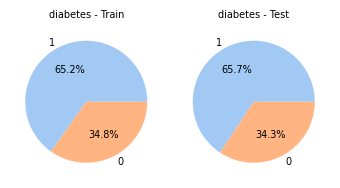

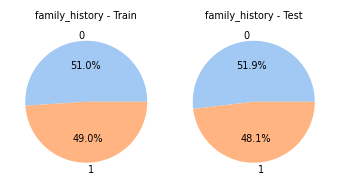

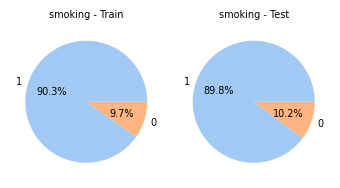

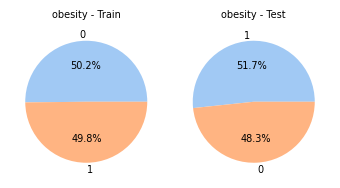

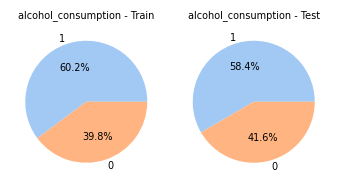

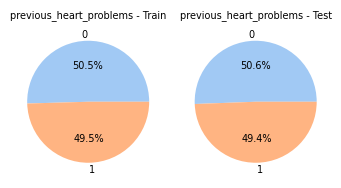

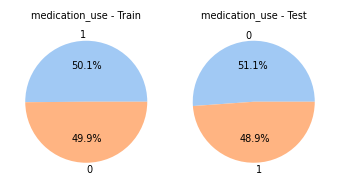

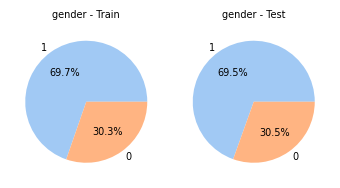

In [233]:
cat_pie(train, test, columns=binary_cols)

По бинарным признакам можно сделать следующие выводы:

1. diabetes: в обоих выборках преобладают больные диабетом (65-66% против 34-35%).

2. family_history: примерно у половины пациентов в обеих выборках есть родственники с заболеваниями, у половины - нет (51-52% против 48-49%). Признак хорошо сбалансирован.

3. smoking: абсолютное большинство пациентов в обеих выборках курят (около 90% против 10%).

4. obesity: распределение признака практически равномерное в обеих выборках (около 50/50), с легким преобладанием пациентов с ожирением.

5. previous_heart_problems: распределение проблем с сердцем в анамнезе практически равномерное (около 50/50) в обеих выборках.

6. medication_use: практически равное распределение пациентов, принимающих и не принимающих лекарства (около 50/50), с небольшим преобладанием принимающих.

7. gender: около 70% пациентов мужского пола в обоих выборках.

Распределение признаков схоже, процентные соотношения для на train и test выборках очень близки. Это показывает хорошую репрезентативность test выборки.

**Количественные признаки**

In [234]:
# функция для количественных признаков
# строит графики для train и test наборов данных для списка признаков
# и усиковую диаграмму
def research_num_comparison_list(train_df, test_df, columns, titles=None, figsize_per_plot=(8, 3)):
    if titles is None: # для названий
        titles = columns
    
    for i, column in enumerate(columns):
        title = titles[i] if i < len(titles) else column
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize_per_plot)
        fig.suptitle(f"{title}", fontsize=10)
        
        # гистограмма для train и test
        # train
        sns.histplot(train_df[column], ax=axes[0], stat='density', alpha=0.5, 
                     label='Train', color='blue', element='step', fill=True)
        # test
        sns.histplot(test_df[column], ax=axes[0], stat='density', alpha=0.3, 
                     label='Test', color='red', element='step', fill=True)
        axes[0].set_title('Сравнение распределений', fontsize=9)
        axes[0].tick_params(axis='both', which='major', labelsize=7)
        axes[0].set_xlabel(title, fontsize=8)
        axes[0].legend(fontsize=8)
        axes[0].set_ylabel('density', fontsize=8)
        axes[0].grid(True)
        
        # усиковые диаграммы для train и test
        data_to_plot = [train_df[column].dropna(), test_df[column].dropna()]
        axes[1].boxplot(data_to_plot, tick_labels=['Train', 'Test'])
        axes[1].set_title('Сравнение разброса значений', fontsize=9)
        axes[1].tick_params(axis='both', which='major', labelsize=7)
        axes[1].set_ylabel(title, fontsize=8)
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

In [235]:
# список количественных признаков
num_cols = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi',
       'triglycerides',
       'sleep_hours_per_day', 'blood_sugar',
       'ck_mb', 'troponin', 'systolic_blood_pressure',
       'diastolic_blood_pressure']
num_cols

['age',
 'cholesterol',
 'heart_rate',
 'exercise_hours_per_week',
 'sedentary_hours_per_day',
 'income',
 'bmi',
 'triglycerides',
 'sleep_hours_per_day',
 'blood_sugar',
 'ck_mb',
 'troponin',
 'systolic_blood_pressure',
 'diastolic_blood_pressure']

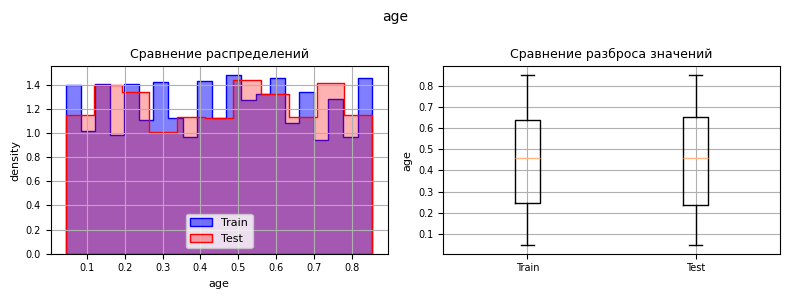

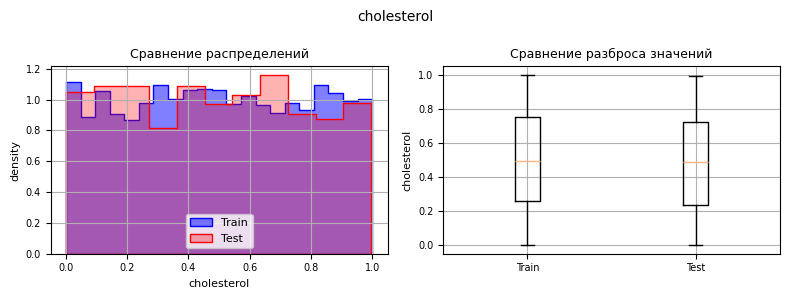

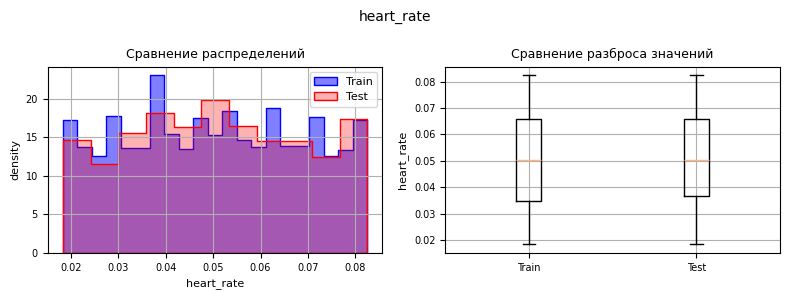

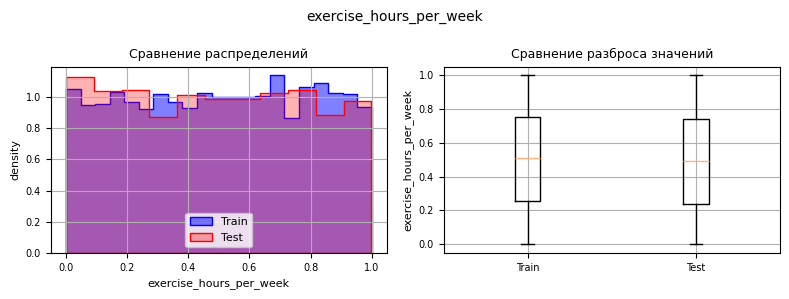

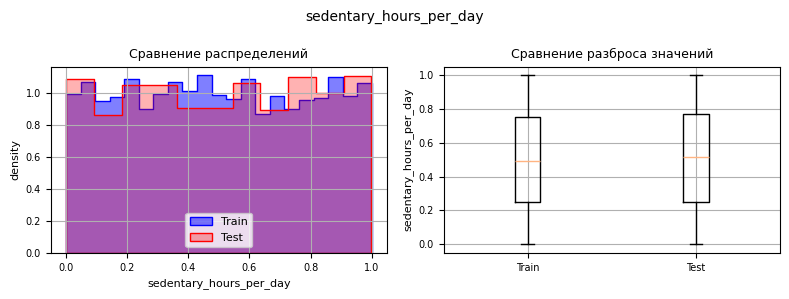

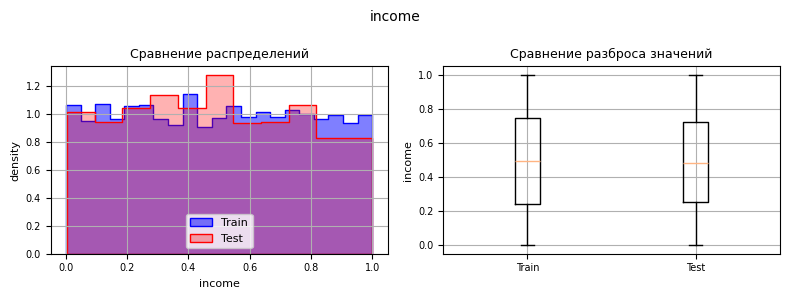

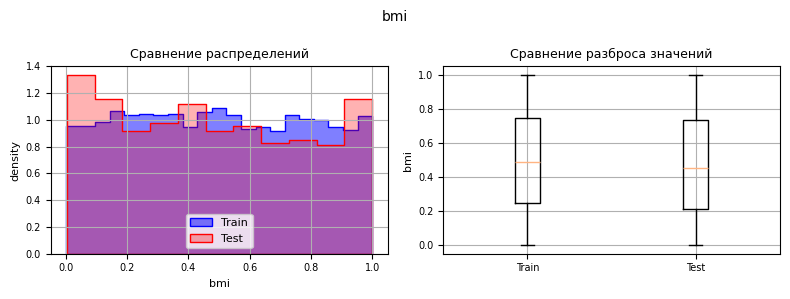

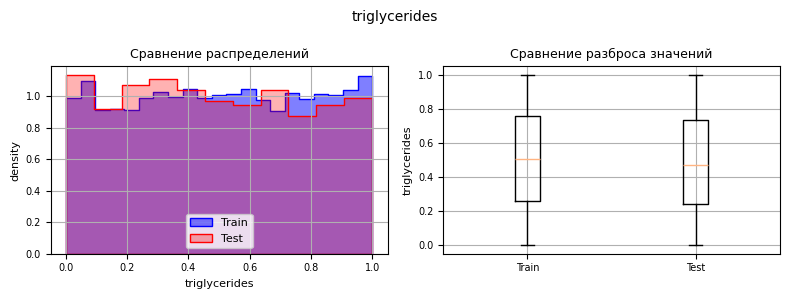

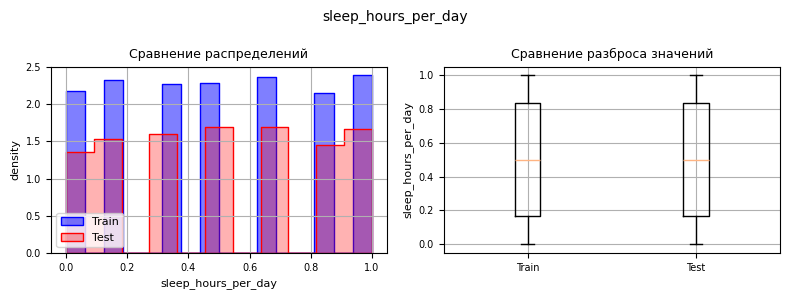

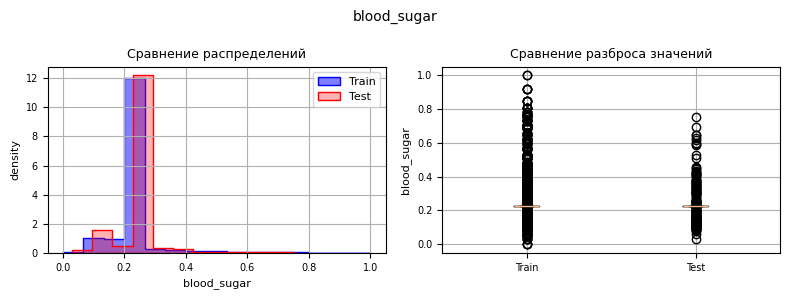

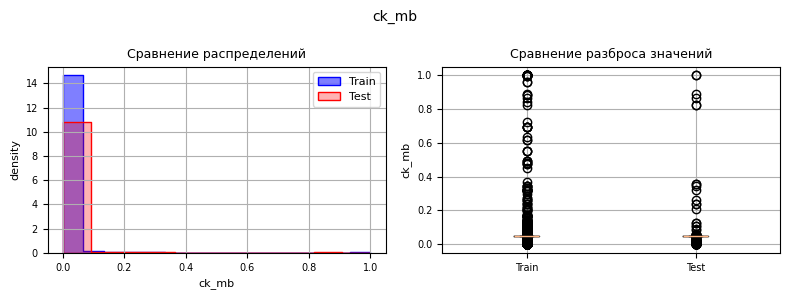

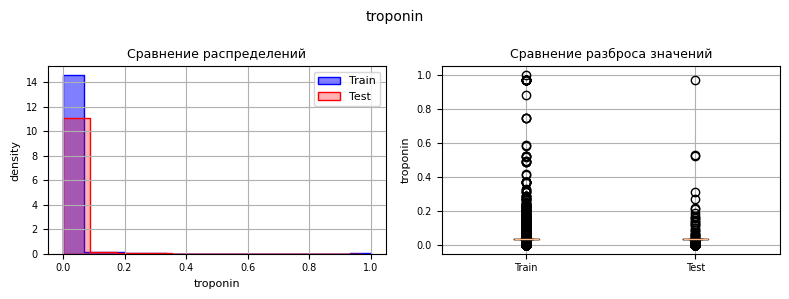

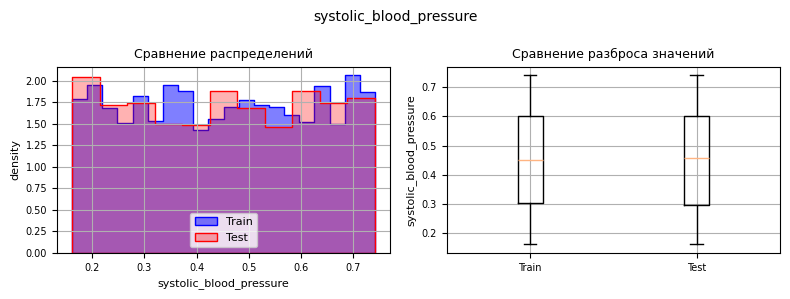

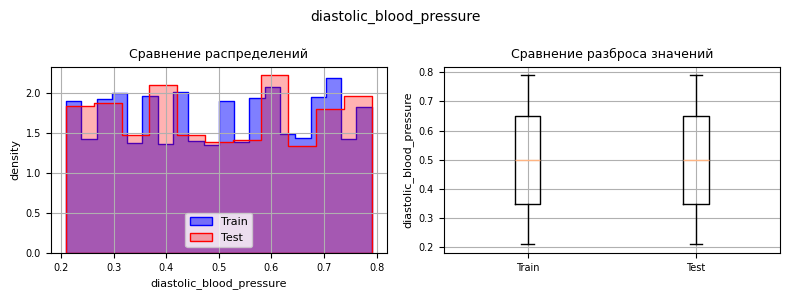

In [236]:
research_num_comparison_list(train, test, columns=num_cols)

Все количественные признаки отнормированы, все лежат в диапазоне между 0 и 1. У большинства признаков (age, cholesterol, heart_rate, evercise_hours_per_week, sedentary_hours_per_day, income, bmi, triglecerides, systolic_blood_pressure, diastolic_blood_pressure) распределены близко к равномерному распределению. Выделяются blood_sugar, ck_mb, troponin - они почти константы.

**Категориальные признаки**

Stress_level, diet и physical_activity_days_per_week - категориальные.

In [237]:
train['stress_level'] = train['stress_level'].apply(
    lambda x: '10' if x >= 10 else '0' if x < 1 else str(int(x))
)

test['stress_level'] = test['stress_level'].apply(
   lambda x: '10' if x >= 10 else '0' if x < 1 else str(int(x))
)

In [238]:
train['physical_activity_days_per_week'] = train['physical_activity_days_per_week'].apply(
   lambda x: '7' if x >= 7 else '0' if x < 1 else str(int(x))
)

test['physical_activity_days_per_week'] = test['physical_activity_days_per_week'].apply(
    lambda x: '7' if x >= 7 else '0' if x < 1 else str(int(x))
)

In [239]:
#train['stress_level'] = train['stress_level'].astype(int) # переведем в тип int
#test['stress_level'] = test['stress_level'].astype(int)

In [240]:
#train['physical_activity_days_per_week'] = train['physical_activity_days_per_week'].astype(int)
#test['physical_activity_days_per_week'] = test['physical_activity_days_per_week'].astype(int)

In [241]:
# построение столбчатых графиков для одного столбца
# и для одного и того же столбца, но в разных датафреймах

def research_cat(*dfs, columns, label, title):
    # если на вход подается один датасет
    if len(dfs) == 1:
        fig, axes = plt.subplots(1, 
                                 1, 
                                 figsize=(6,5)) # строим один график
        axes = [axes]  # преобразуем в список
        fig.suptitle(f"{title}", fontsize=16) # пишем подпись для этого графика
        colors = plt.cm.Set2.colors[:len(dfs)]  # используем цветовую палитру Set1
    
    # если на вход подается больше одного датасета
    else:
        fig, axes = plt.subplots(1, len(dfs), figsize=(8, 2.5)) # строим графиков по числу таблиц
        fig.suptitle(f"{title}", fontsize=10)
        colors = plt.cm.Set1.colors[:len(dfs)]

    # перебираем i - оси, df - датасеты, строим столбчатые диаграммы
    for i, df in enumerate(dfs):
        df[columns].value_counts().plot(kind='bar', 
                                  grid=True,
                                  ax=axes[i],
                                  xlabel=label,
                                  ylabel='Frequency',
                                  color=colors[i])
    # выводим    
    plt.show()

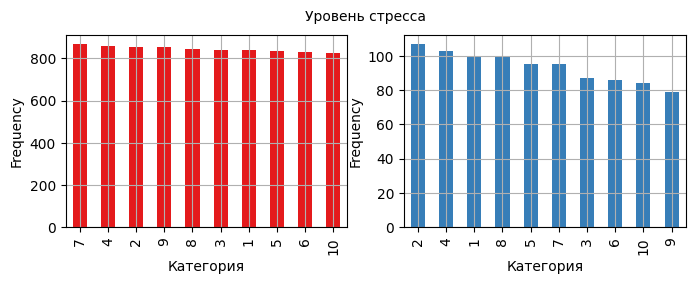

In [242]:
research_cat(train, test, columns='stress_level', label='Категория', title='Уровень стресса')

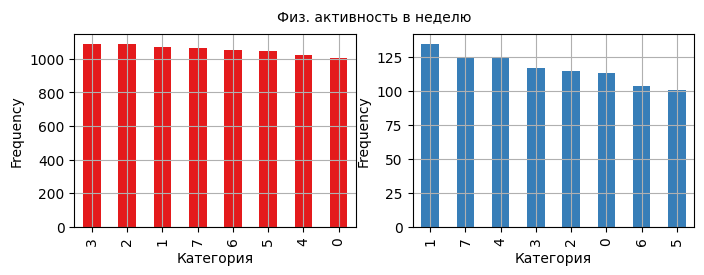

In [243]:
research_cat(train, test, columns='physical_activity_days_per_week', label='Категория', title='Физ. активность в неделю')

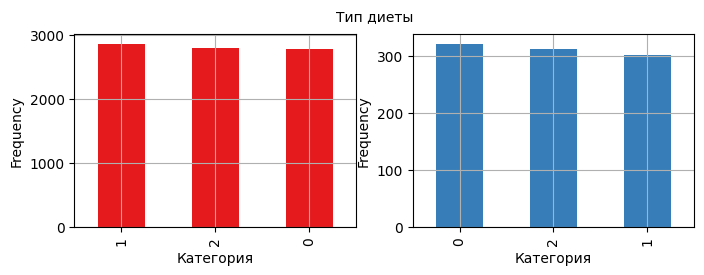

In [244]:
research_cat(train, test, columns='diet', label='Категория', title='Тип диеты')

Перевели признаки stress_level, physical_activity_days_per_week в категориальные.

Теперь посмотрим на распределение таргета.

**Таргет**

In [245]:
# переименуем
train = train.rename(columns={'heart_attack_risk_(binary)': 'heart_attack_risk'})
# сделаем тип int
train['heart_attack_risk'] = train['heart_attack_risk'].astype(int)

In [246]:
no_risk_count = train[train['heart_attack_risk'] == 0].shape[0] # без риска
risk_count = train[train['heart_attack_risk'] == 1].shape[0] # с риском
total_count = len(train)

# расчитываем проценты
no_risk_percentage = (no_risk_count / total_count) * 100
risk_percentage = (risk_count / total_count) * 100

print(f"Без риска: {no_risk_count} ({no_risk_percentage:.2f}%)")
print(f"С риском: {risk_count} ({risk_percentage:.2f}%)")
print(f"Общее: {total_count}")

Без риска: 5429 (64.31%)
С риском: 3013 (35.69%)
Общее: 8442


В тренировочных даннных у 64% записей нет риска сердечного приступа, у 35% есть. Построим графики признаков в зависимости от наличия\отсутствия риска.

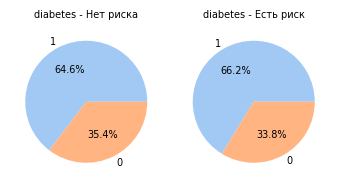

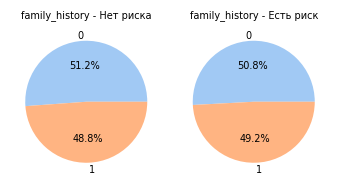

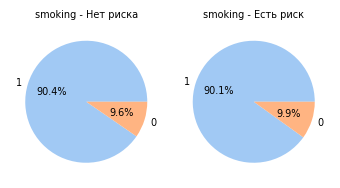

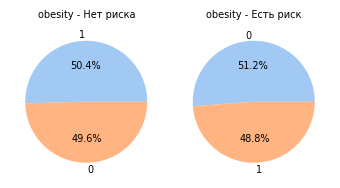

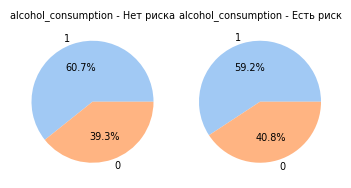

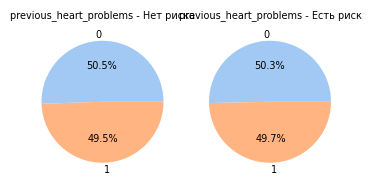

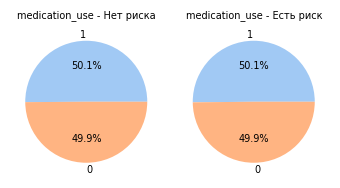

In [247]:
no_risk = train[train['heart_attack_risk'] == 0]
risk = train[train['heart_attack_risk'] == 1]

cat_pie(no_risk, risk, binary, name1='Нет риска', name2='Есть риск')

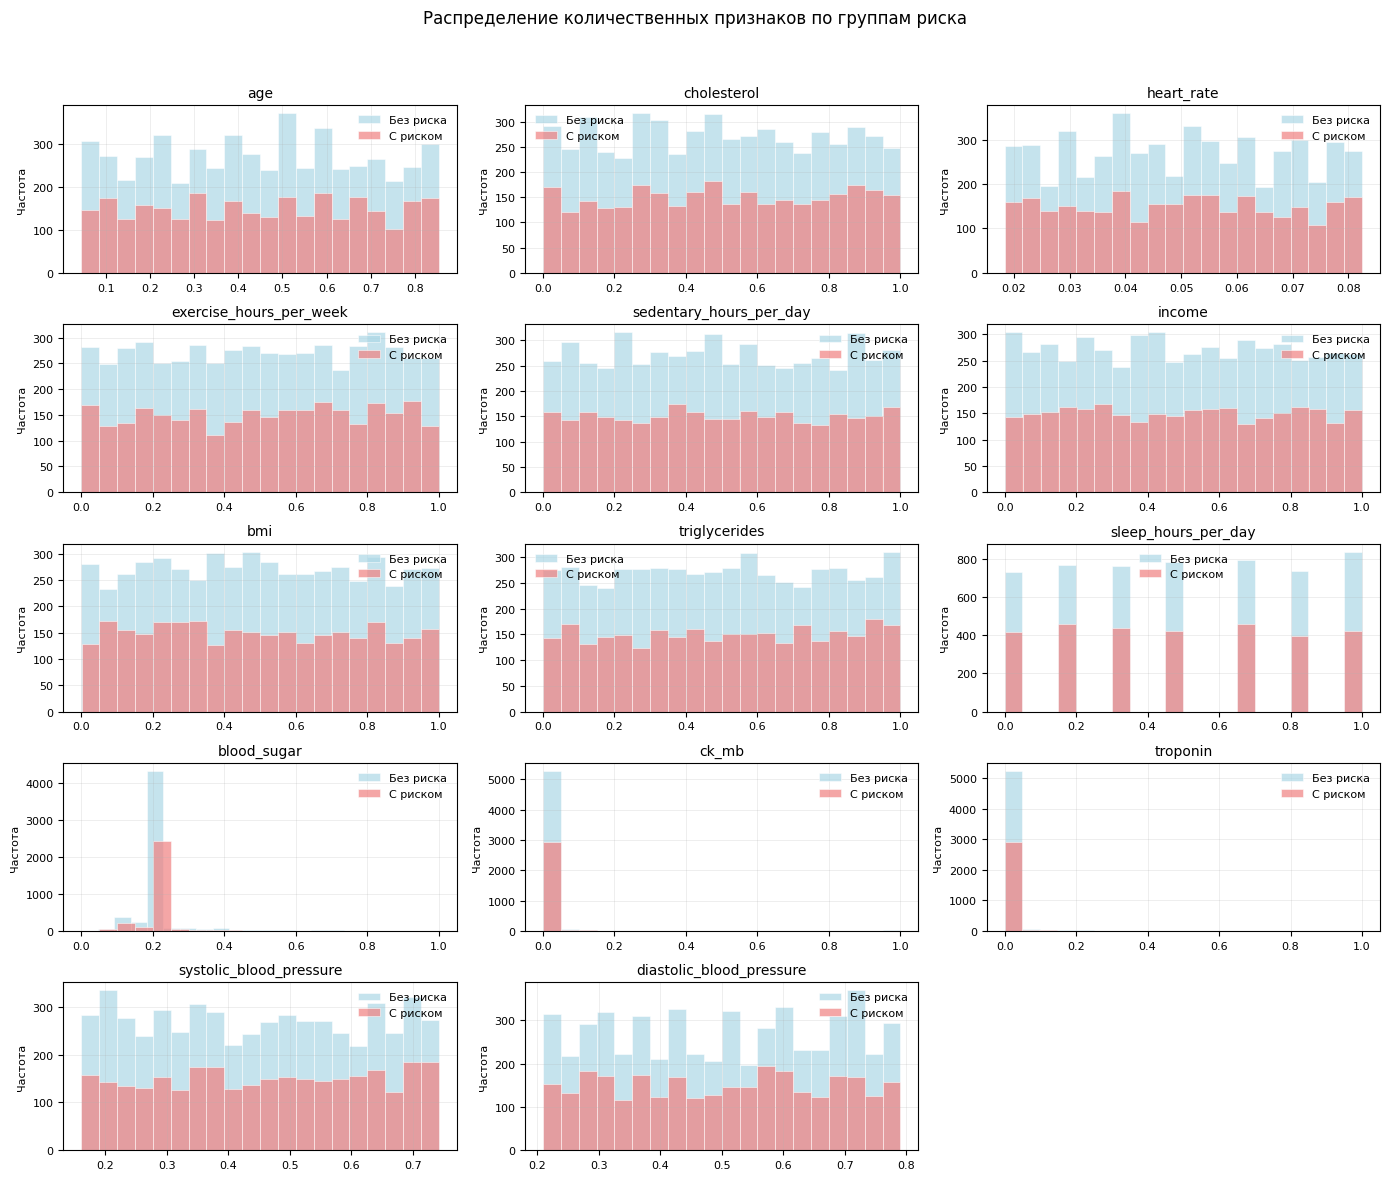

In [248]:
# cоздаем сетку графиков
fig, axes = plt.subplots(5, 3, figsize=(14, 12))  # 5 строк, 3 столбца
axes = axes.ravel()  

# для каждого количественного признака строим гистограммы
for i, feature in enumerate(num_cols):
    if i < len(axes):  
        # без риска
        axes[i].hist(no_risk[feature], bins=20, alpha=0.7, label='Без риска', 
                    color='lightblue', edgecolor='white', linewidth=0.5)
        
        axes[i].hist(risk[feature], bins=20, alpha=0.7, label='С риском', 
                    color='lightcoral', edgecolor='white', linewidth=0.5)

        axes[i].set_title(feature, fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Частота', fontsize=8)
        axes[i].tick_params(axis='both', which='major', labelsize=8)
        axes[i].legend(fontsize=8, frameon=False)
        
        axes[i].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# убираем лишние пустые подграфики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Распределение количественных признаков по группам риска', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9) 

plt.show()

Распределения для признаков без риск сердечного приступа и с риском в целом не сильно отличаются с поправкой на соотношение числа записей. Для бинарных признаков заметна аномалияв признаке smoking с соотношением 90%\10%, причем соотношение одинаковое и для без риска и с риском сердечного приступа.

Для признаков blood_sugar, ck_mb, troponin заметны почти константные значения и малое число выбросов. Вероятно, это связано с тем, что, в отличии, например, от холестирина, в норме у человека эти значения будут в узком диапазоне. При этом, если есть какое-то нарушение работы сердца, то оно будет заметно для признаков ферментов.

**Корреляционный анализ**

Построим матрицу корреляции phik.

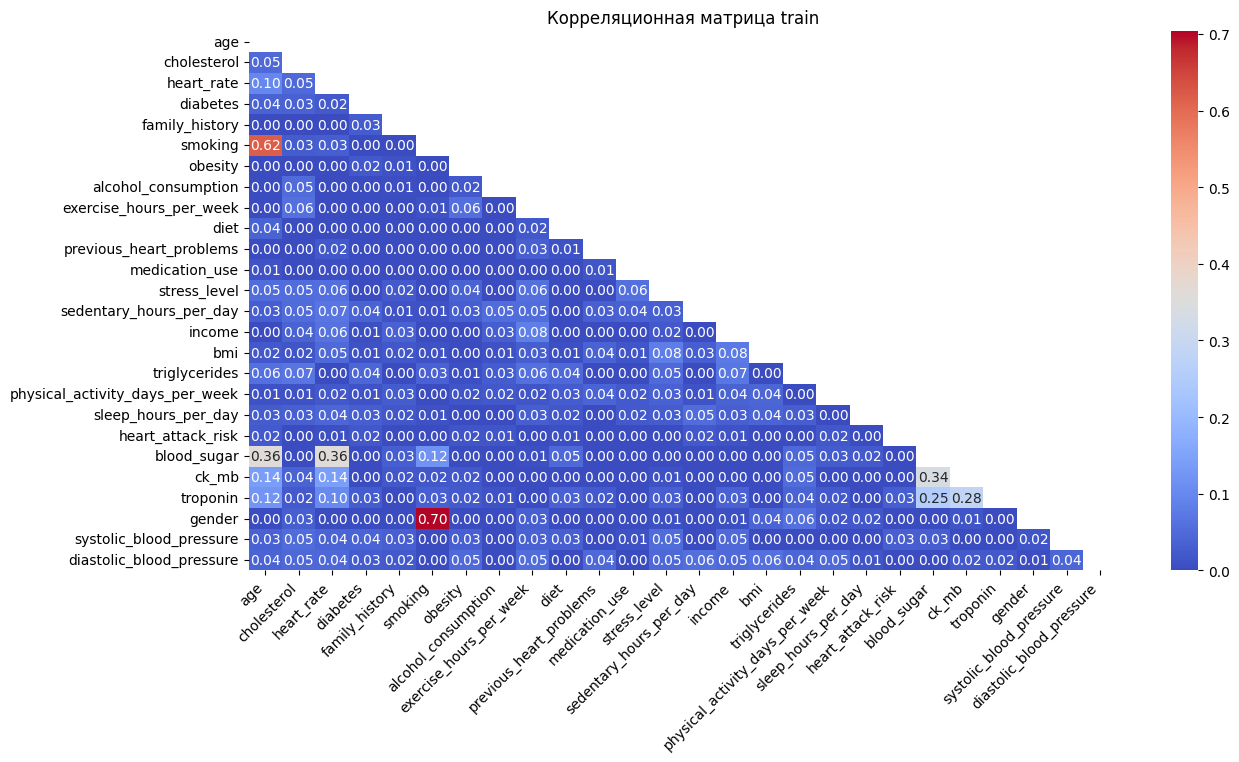

In [249]:
# train
phik_matrix_train = train.drop('id', axis=1).phik_matrix(interval_cols=num_cols)

# визуализация корреляционной матрицы 
mask = np.triu(np.ones_like(phik_matrix_train, dtype=bool))

plt.figure(figsize=(14, 7))
sns.heatmap(phik_matrix_train, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.xticks(rotation=45, ha='right')
plt.title("Корреляционная матрица train")
plt.show()

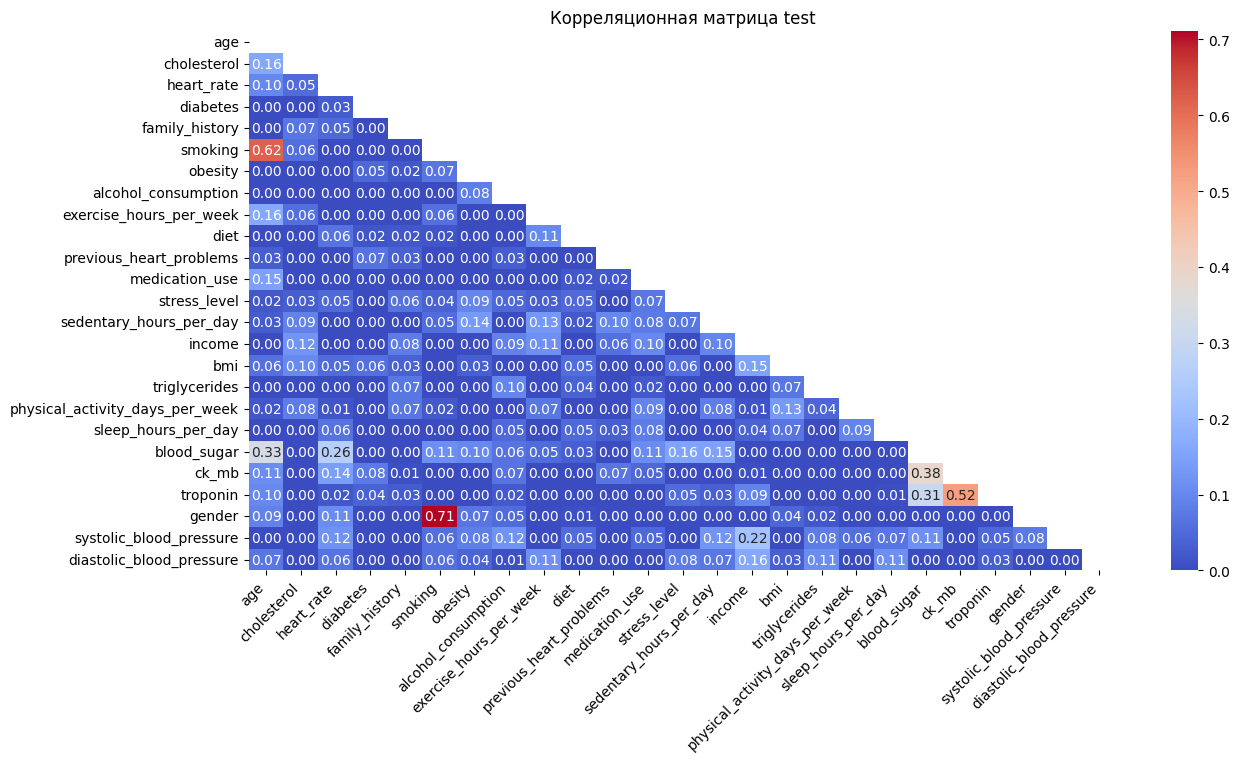

In [250]:
# test
phik_matrix_test = test.drop('id', axis=1).phik_matrix(interval_cols=num_cols)

# визуализация корреляционной матрицы 
mask = np.triu(np.ones_like(phik_matrix_test, dtype=bool))

plt.figure(figsize=(14, 7))
sns.heatmap(phik_matrix_test, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.xticks(rotation=45, ha='right')
plt.title("Корреляционная матрица test")
plt.show()

По матрицы корреляции phik для train и test можно сделать следующие выводы:

1. Целевой признак heart_attack_risk не коррелирует с другими признаками.
2. Есть заметная мультикорреляция: признак smoking коррелирует с age (0.62) и с gender (0.7 на train, 0.71 на test). Следует его удалить.
3. Есть невысокая мультикорреляция между признаками ck_mb, troponin, blood_sugar. 

**Вывод**

В ходе исследовательского анализа были сделаны следующие выводы:

1. Построены графики для бинарных признаков. В целом признаки хорошо сбалансированы, однако наблюдается несколько признаков с дисбалансом: smoking: ярко выраженный перекос (90% курящих); gender: значительное преобладание пациентов мужского пола (70%), diabetes: больных диабетом больше (65%). Можно также сделать вывод, что выборка test репрезентативна, потому что ее распределение признаков близко к распределению test.

2. Построены графики для количественных признаков. Все признаки отнормированы, все лежат в диапазоне между 0 и 1. У большинства признаков (age, cholesterol, heart_rate, evercise_hours_per_week, sedentary_hours_per_day, income, bmi, triglecerides, systolic_blood_pressure, diastolic_blood_pressure) распределены близко к равномерному распределению. Выделяются blood_sugar, ck_mb, troponin - они почти константы. Вероятно, это связано с тем, что, в отличии, например, от холестирина, в норме у человека эти значения будут в узком диапазоне. При этом, если есть какое-то нарушение работы сердца, то оно будет заметно для признаков ферментов.

3. Построены графики для категориальных признаков. Признаки stress_level, physical_activity_days_per_week переведены в категориальные. Сильного преобладания какой-либо категории нет.

4. Исследован целевой признак heart_attack_risk. У 64-х% случаев train нет риска сердечного приступа, у 35% он есть. Исследованы распределения бинарных и количественных признаков по группам "нет риска" и "есть риск". Сильной разницы между признаками не обнаружено.

5. Проведен корреляционный анализ, построена матрица корреляции коэффициента phik. Целевой признак heart_attack_risk не коррелирует с другими признаками. Есть заметная мультикорреляция: признак smoking коррелирует с age (0.62) и с gender (0.7 на train, 0.71 на test). Следует его удалить.
Есть невысокая мультикорреляция между признаками ck_mb, troponin, blood_sugar.


Признаки ck_mb и troponin, вероятно, являются **утечками целевого признака**. Креатинкиназа (ck_mb) в крови здорового человека присутствует в совсем незначительных количествах. Она повышается в следствии инфаркта миокарда (сердечного приступа). Тропонин - белок, содержащийся в клетках сердечной мышцы, и при повреждении миокарда (как при инфаркте) высвобождается в кровь. Оба этих показателя используются в диагностике, но уже для прогноза развития болезни, так как до сердечного приступа они никак не изменятся.

В следствии мультиколлеарности так же принято решение удалить признак smoking.

Также будут удалены признаки blood_sugar, потому что у него тоже есть мультикорреляция и очень много выросов и income, потому что нет логической связи между уровнем зарплаты и риском сердечного приступа, а еще без него модель работает лучше.

## Обучение модели

In [251]:
# пробуем без blood_sugar
train = train.drop(['blood_sugar'], axis=1)
test = test.drop(['blood_sugar'], axis=1)

In [252]:
# пробуем без income
train = train.drop(['income'], axis=1)
test = test.drop(['income'], axis=1)

In [253]:
# удалим столбцы
train = train.drop(['smoking', 'ck_mb', 'troponin'], axis=1)
test = test.drop(['smoking', 'ck_mb', 'troponin'], axis=1)

In [254]:
# константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [255]:
y = train['heart_attack_risk']
X = train.drop(['heart_attack_risk', 'id'], axis=1)

In [256]:
# разбиваем на валидационную и обучающую
X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE,
        stratify=y 
    )

In [257]:
# проверяем размеры
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(6331, 20)
(2111, 20)
(6331,)
(2111,)


Данные уже нормированы. Будем кодировать категориальные признаки с помощью OneHotEncoder (diet) и OrdinalEncoder (stress_level, physical_activity_days_per_week). Стоит задача классификации: предсказания класса 1 - есть риск сердечного приступа, 0 - нет риска. Таблица train разделена на тренировочную и валидационную выборку в соотношении 75:25.

Будем использовать DecisionTreeClassifier, RandomForest, KNN, LogisticRegression из библиотеки sklearn, CatBoostClassifier из библиотеки CatBoost и XGBClassifier из Xgboost. Перебирать гиперпараметры будем RandomSearchCV. В качестве основной метрики оценки работы модели будем использовать ROC-AUC как одну из наиболее удобных в задаче классификации метрик.

In [258]:
train['stress_level'].value_counts()

stress_level
7     869
4     857
2     854
9     852
8     844
3     841
1     840
5     833
6     828
10    824
Name: count, dtype: int64

In [259]:
train['physical_activity_days_per_week'].value_counts()

physical_activity_days_per_week
3    1091
2    1087
1    1069
7    1063
6    1055
5    1046
4    1025
0    1006
Name: count, dtype: int64

In [266]:
ohe_cols = ['diet']
ord_cols = ['stress_level', 'physical_activity_days_per_week']

# OneHotEncoder для категориальных признаков
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='error'))
])

# OrdinalEncoder для порядковых признаков с числовыми категориями
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        categories=[
            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # для stress_level
            [0, 1, 2, 3, 4, 5, 6, 7]          # для physical_activity
        ],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols)
    ],
    remainder='passthrough'
)

In [267]:
pipe = Pipeline([
    ('preprocessor', preprocessor),  
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))  
])

param_distributions = [
    # Decision Tree
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': np.arange(2, 21),
        'models__min_samples_split': np.arange(2, 11),
        'models__min_samples_leaf': np.arange(1, 11),
        'models__class_weight': [None, 'balanced']
    },
    
    # KNN
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': np.arange(3, 21),
        'models__weights': ['uniform', 'distance'],
        'models__p': [1, 2]  
    },

    # Logistic Regression
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__C': np.logspace(-3, 3, 7),
        'models__class_weight': [None, 'balanced']
    },
    
    # Random Forest 
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': [None, 5, 10, 15],
        'models__min_samples_split': [2, 5, 10],
        'models__class_weight': [None, 'balanced']
    },
    
    # XGBoost
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')],
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.001, 0.01, 0.1, 0.2],
        'models__max_depth': [3, 5, 7, 9],
        'models__subsample': [0.8, 0.9, 1.0],
        'models__colsample_bytree': [0.8, 0.9, 1.0]
    },
    
    # CatBoost
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'models__iterations': [100, 200, 300],
        'models__learning_rate': [0.001, 0.01, 0.1, 0.2],
        'models__depth': [4, 6, 8, 10]
    }
]


In [268]:
# RandomizedSearchCV с ROC-AUC
random_search = RandomizedSearchCV(
    pipe, 
    param_distributions, 
    n_iter=50,  
    cv=5,
    scoring='roc_auc',  
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
    error_score='raise'  # чтобы видеть ошибки сразу
)

try:
    random_search.fit(X_train, y_train)
    
    print(f'Лучшая модель и её параметры:\n', random_search.best_params_)
    print(f'Метрика ROC-AUC лучшей модели на кросс-валидации: {random_search.best_score_:.3f}')

    # предсказываем
    y_pred = random_search.predict(X_val)
    y_pred_proba = random_search.predict_proba(X_val)[:, 1]

    f1_val = f1_score(y_val, y_pred) # F1
    roc_auc_val = roc_auc_score(y_val, y_pred_proba) # ROC-AUC
    acc_val = accuracy_score(y_val, y_pred) # Accuracy

    print(f'Метрика F1-score на валидационной выборке: {f1_val:.3f}')
    print(f'Метрика ROC-AUC на валидационной выборке: {roc_auc_val:.3f}')
    print(f'Метрика Accuracy на валидационной выборке: {acc_val:.3f}')
    
except Exception as e:
    print(f"Произошла ошибка: {e}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшая модель и её параметры:
 {'models__n_estimators': 300, 'models__min_samples_split': 5, 'models__max_depth': 15, 'models__class_weight': None, 'models': RandomForestClassifier(random_state=42)}
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.572
Метрика F1-score на валидационной выборке: 0.124
Метрика ROC-AUC на валидационной выборке: 0.594
Метрика Accuracy на валидационной выборке: 0.665


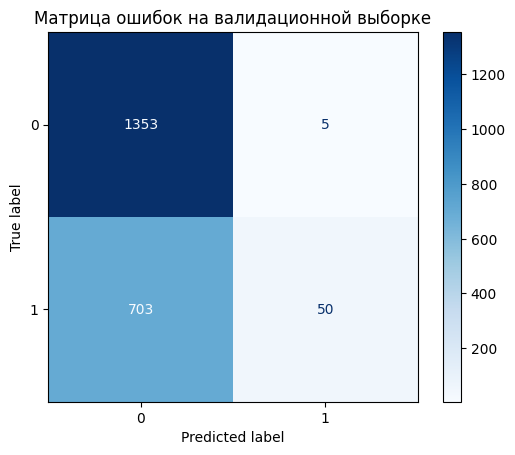

In [269]:
# вычисляем матрицу ошибок
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Матрица ошибок на валидационной выборке')
plt.show()

Мы обучили модель на тренировочных данных и проверили ее работу на валидационных. Лучшая модель по результатам RandomSearch с метрикой ROC-AUC оказалась RandomForest. Ее ROC-AUC на тренировочных данных cоставляет 0.572, на валидационных 0.594. Дополнительные метрики F1 0.124 - очень низкий, и accuracy 0.665.

В задаче нам необходимо минимизировать ошибку False Negative, то есть нестрашно, когда человеку ошибочно ставят риск сердечного приступа (1), но плохо, если риск сердечного приступа не определят. На данный момент есть 703 ошибок False Negative. Нам необходимо минимизировать ошибку второго рода и сделать так, чтобы метрика recall стала высокой.

Попробуем отрегулировать пороги классификации.

In [270]:
# получаем вероятности для положительного класса
y_pred_proba = random_search.predict_proba(X_val)[:, 1]

thresholds = [0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
recall_scores = []

In [271]:
data = pd.DataFrame(zip(y_val, y_pred_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
data.head()

,y_valid,y_proba,y_pred_0.1,y_pred_0.12,y_pred_0.15,y_pred_0.18,y_pred_0.2,y_pred_0.25,y_pred_0.3,y_pred_0.35,y_pred_0.4,y_pred_0.45,y_pred_0.5
0,1,0.307186,1,1,1,1,1,1,1,0,0,0,0
1,0,0.419600,1,1,1,1,1,1,1,1,1,0,0
2,0,0.410323,1,1,1,1,1,1,1,1,1,0,0
3,1,0.354857,1,1,1,1,1,1,1,1,0,0,0
4,1,0.328036,1,1,1,1,1,1,1,0,0,0,0


In [272]:
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    recall_val = recall_score(y_val, y_pred_custom, zero_division=0)
    print(f"Recall для порога {threshold}: {recall_val:.6f}")

Recall для порога 0.1: 1.000000
Recall для порога 0.12: 1.000000
Recall для порога 0.15: 1.000000
Recall для порога 0.18: 1.000000
Recall для порога 0.2: 1.000000
Recall для порога 0.25: 0.998672
Recall для порога 0.3: 0.942895
Recall для порога 0.35: 0.612218
Recall для порога 0.4: 0.268260
Recall для порога 0.45: 0.112882
Recall для порога 0.5: 0.066401


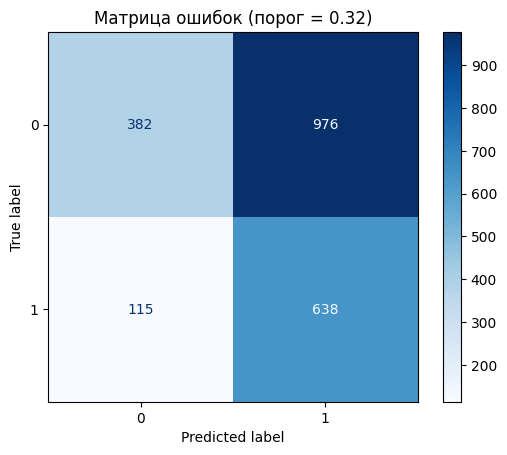

In [285]:
# построим матрицу для порога 0.32
y_pred_custom = (y_pred_proba >= 0.32).astype(int)

# Строим матрицу ошибок
cm = confusion_matrix(y_val, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Матрица ошибок (порог = 0.32)')
plt.show()


Я попробовала несколько порогов и выбрала 0.32. Он не минимизирует полностью recall, но создает хорошее равновесие с ошибками FN 115, FP 976, TP 630. Посчитаем точные recall и precision.

In [286]:
accuracy = accuracy_score(y_val, y_pred_custom)
precision = precision_score(y_val, y_pred_custom)
recall = recall_score(y_val, y_pred_custom)

print(f'Accuracy', accuracy)
print(f'Precision', precision)
print(f'Recall', recall)

Accuracy 0.48318332543818093
Precision 0.3952912019826518
Recall 0.8472775564409031


Для порога 0.33 получили precision 0.395 и recall 0.847.

Построим ROC-AUC кривую.

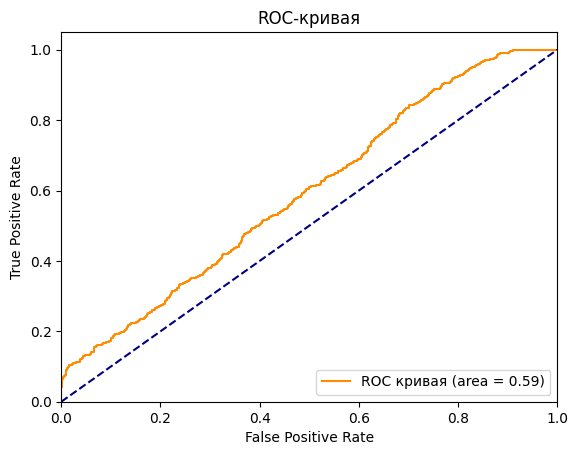

In [287]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

В идеале ROC-кривая должна вытягиваться к значению (0, 1). Площадь под графиком auc составляет 0.6. Исследуем важность признаков.

In [278]:
# Получаем имена признаков после препроцессинга
preprocessor = random_search.best_estimator_.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['ohe__diet_1', 'ohe__diet_2', 'ord__stress_level',
       'ord__physical_activity_days_per_week', 'remainder__age',
       'remainder__cholesterol', 'remainder__heart_rate',
       'remainder__diabetes', 'remainder__family_history',
       'remainder__obesity', 'remainder__alcohol_consumption',
       'remainder__exercise_hours_per_week',
       'remainder__previous_heart_problems', 'remainder__medication_use',
       'remainder__sedentary_hours_per_day', 'remainder__bmi',
       'remainder__triglycerides', 'remainder__sleep_hours_per_day',
       'remainder__gender', 'remainder__systolic_blood_pressure',
       'remainder__diastolic_blood_pressure'], dtype=object)

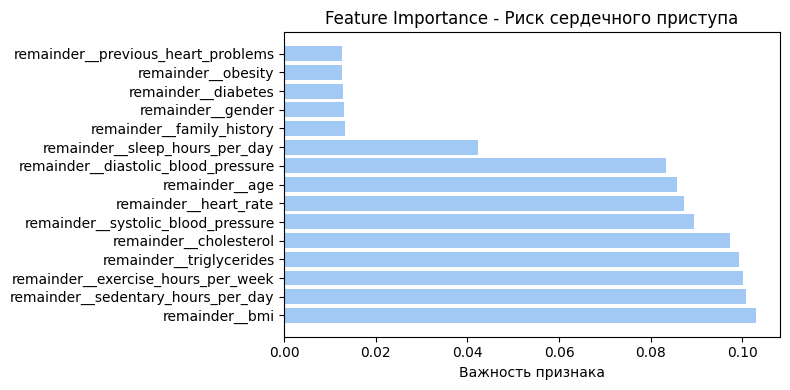

In [279]:
# берем feature_importances лучшей модели
feature_importance = random_search.best_estimator_.named_steps['models'].feature_importances_

# для визуализации
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# bar plot
plt.figure(figsize=(8, 4))
plt.barh(importance_df['feature'][:15], importance_df['importance'][:15])
plt.title('Feature Importance - Риск сердечного приступа')
plt.xlabel('Важность признака')
plt.tight_layout()
plt.show()

Судя по графику feature importance самым важным для модели признаком является bmi. Также важны sedentary_hours_per_day и exercise_hours_per_week.

Порог подобрали, лучшей моделью сделаем предсказания на test данных.

**Вывод**: 

1. Разделили данные train на тренировочную и валидационную подвыборки в соотношении 75:25.
2. Создали пайплайн с гиперпараметрами моделей. Использовали DecisionTreeClassifier, RandomForest, KNN, LogisticRegression из библиотеки sklearn, CatBoostClassifier из библиотеки CatBoost и XGBClassifier из Xgboost. Перебрали гиперпараметры RandomSearchCV. В качестве основной метрики оценки работы модели использовали ROC-AUC как одну из наиболее удобных в задаче классификации метрик.
3. Лучший результат на тренировочной выборке показала модель RandomForest с результатом ROC-AUC на тренировочных данных cоставляет 0.565, на валидационных 0.597 (довольно низкий, однако попытка улучшить его с помощью imblearn ни к чему не привела).
4. Построена матрица ошибок и определено, что необходимо минимизировать ошибку второго рода (716).
5. Определен подходящий порог 0.33,  precision 0.403 и recall 0.806 с ошибками FN 146, FP 897, TP 607.
6. Построен график feature importances И определено, что самыми важными признаками для модели являются bmi, exercise_hours_per_week и income.

## Submission

In [135]:
# сохраним id
test_ids = test['id'].astype(object)
X_test = test.drop('id', axis=1)

In [136]:
test_proba = random_search.predict_proba(X_test)

In [137]:
test_predictions = (test_proba[:, 1] >= 0.33).astype(int) # выбранный порог

submission = pd.DataFrame({
        'id': test_ids,
        'prediction': test_predictions
    })

In [138]:
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно сохранен!")
    
print("\nПервые 5 строк файла предсказаний:")
print(submission.head())

Файл submission.csv успешно сохранен!

Первые 5 строк файла предсказаний:
     id  prediction
0  7746           0
1  4202           1
2  6632           1
3  4639           0
4  4825           0
